## Import libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import featuretools as ft
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_rows', 100)

## Load source datasets

In [2]:
train = pd.read_csv("../input/deloitte-ml-challenge/train.csv")
train.set_index('ID', inplace=True)
print(f"train: {train.shape}")
train.head()

train: (67463, 34)


,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [3]:
test = pd.read_csv("../input/deloitte-ml-challenge/test.csv")
test.set_index('ID', inplace=True)
print(f"test: {test.shape}")
test.head()

test: (28913, 34)


,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
ID,,,,,,,,,,,,,,,,,,,,,
56492997,17120,10365,16025.082690,59,BAT2575549,12.163926,A,D1,RENT,76468.82190,...,8.425776,0.731797,0,INDIVIDUAL,135,0,24,475442,4364,NaN
22540813,7133,11650,12615.795600,59,BAT2833642,6.564296,B,E3,MORTGAGE,38079.01344,...,6.157008,0.992918,0,INDIVIDUAL,56,0,1,72412,2573,NaN
9862181,25291,25825,11621.280830,59,BAT1761981,14.729900,A,C3,MORTGAGE,51275.93268,...,5.705077,0.281580,0,INDIVIDUAL,3,0,26,284825,19676,NaN
10097822,30781,9664,15375.823510,59,BAT5341619,10.523767,A,A2,RENT,68867.98965,...,2.469688,0.959162,0,INDIVIDUAL,21,0,32,40842,7226,NaN
47771809,8878,9419,7176.647582,58,BAT4694572,9.997013,C,B3,OWN,91556.85423,...,2.127835,0.402315,0,INDIVIDUAL,104,0,33,90825,26145,NaN


## EDA + Data Preprocessing

In [4]:
train.isnull().sum()

Loan Amount                     0
Funded Amount                   0
Funded Amount Investor          0
Term                            0
Batch Enrolled                  0
Interest Rate                   0
Grade                           0
Sub Grade                       0
Employment Duration             0
Home Ownership                  0
Verification Status             0
Payment Plan                    0
Loan Title                      0
Debit to Income                 0
Delinquency - two years         0
Inquires - six months           0
Open Account                    0
Public Record                   0
Revolving Balance               0
Revolving Utilities             0
Total Accounts                  0
Initial List Status             0
Total Received Interest         0
Total Received Late Fee         0
Recoveries                      0
Collection Recovery Fee         0
Collection 12 months Medical    0
Application Type                0
Last week Pay                   0
Accounts Delin

In [5]:
test.isnull().sum()

Loan Amount                         0
Funded Amount                       0
Funded Amount Investor              0
Term                                0
Batch Enrolled                      0
Interest Rate                       0
Grade                               0
Sub Grade                           0
Employment Duration                 0
Home Ownership                      0
Verification Status                 0
Payment Plan                        0
Loan Title                          0
Debit to Income                     0
Delinquency - two years             0
Inquires - six months               0
Open Account                        0
Public Record                       0
Revolving Balance                   0
Revolving Utilities                 0
Total Accounts                      0
Initial List Status                 0
Total Received Interest             0
Total Received Late Fee             0
Recoveries                          0
Collection Recovery Fee             0
Collection 1

### Examine target

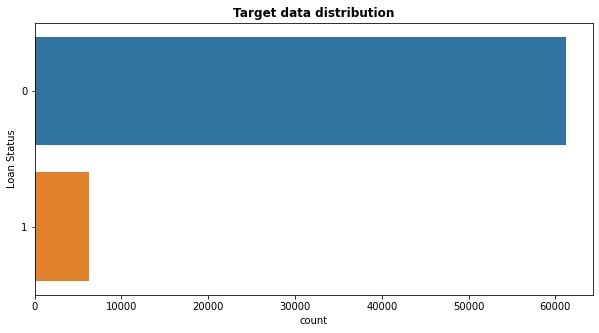

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Loan Status', data=train)
plt.title("Target data distribution", fontweight='bold');

### Loan Amount

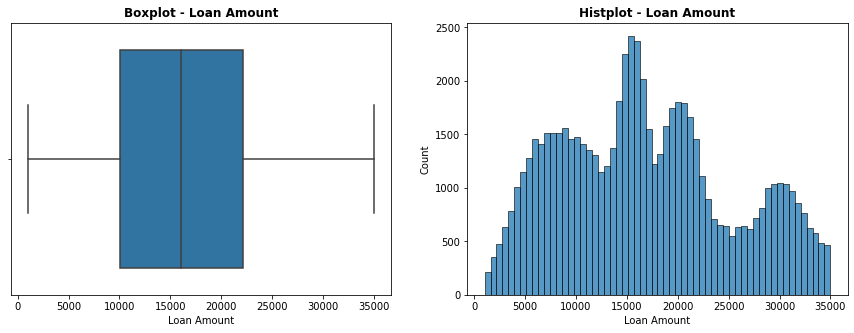

In [7]:
col = 'Loan Amount'
x1 = train[col]

_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');

### Funded Amount

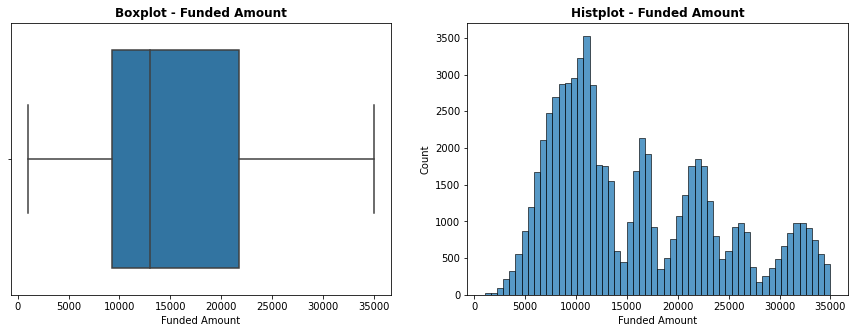

In [8]:
col = 'Funded Amount'
x1 = train[col]

_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');

### Funded Amount Investor

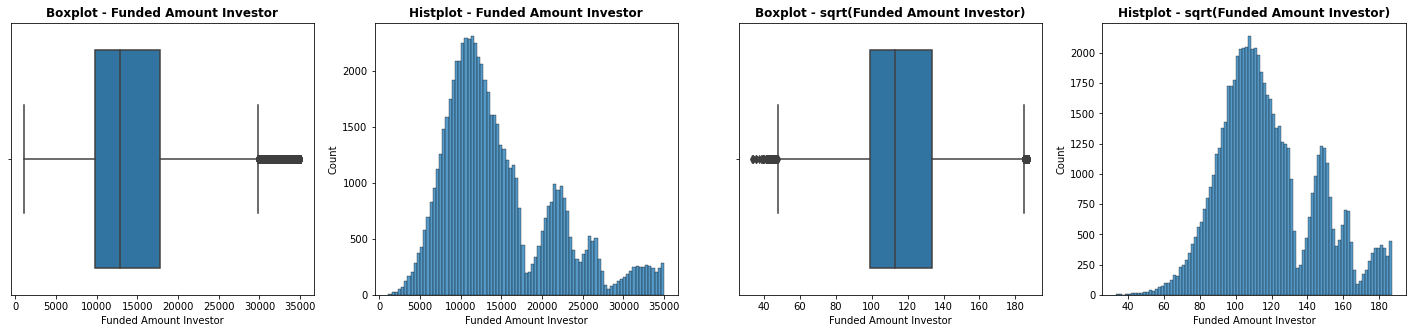

In [9]:
col = 'Funded Amount Investor'
x1 = train[col]
x2 = np.sqrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - sqrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - sqrt({col})", fontweight='bold');

In [10]:
train['Funded Amount Investor'] = np.sqrt(train['Funded Amount Investor'])
test['Funded Amount Investor'] = np.sqrt(test['Funded Amount Investor'])

### Term

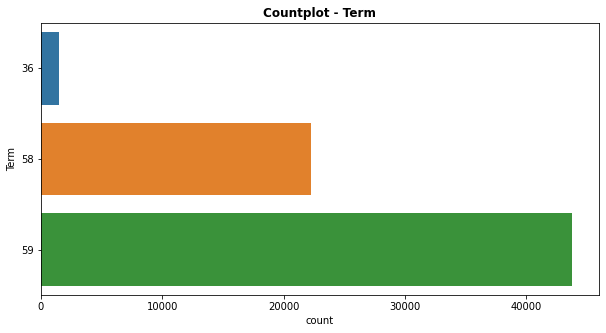

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Term', data=train)
plt.title("Countplot - Term", fontweight='bold');

### Batch Enrolled

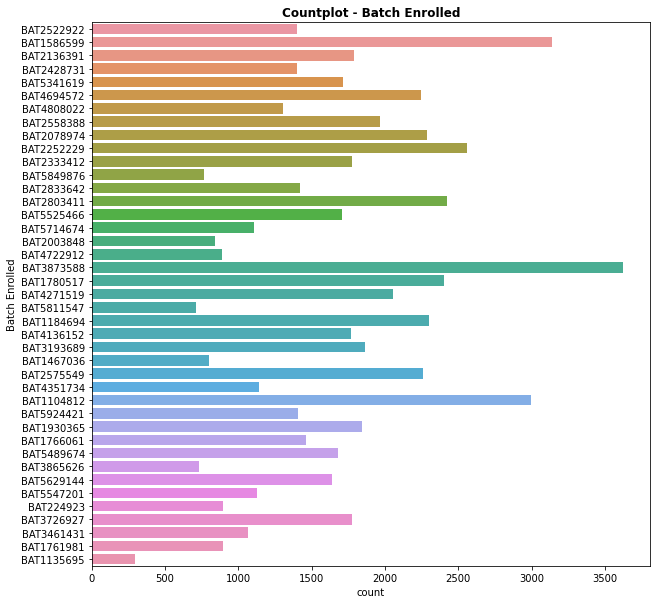

In [12]:
plt.figure(figsize=(10, 10))
sns.countplot(y='Batch Enrolled', data=train)
plt.title("Countplot - Batch Enrolled", fontweight='bold');

In [13]:
le = LabelEncoder().fit(train['Batch Enrolled'].append(test['Batch Enrolled']))
train['Batch Enrolled'] = le.transform(train['Batch Enrolled'])
test['Batch Enrolled'] = le.transform(test['Batch Enrolled'])
train.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,111.037664,59,16,11.135007,B,C4,MORTGAGE,176346.62670,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1450153,3609,11940,110.417376,59,4,12.237563,C,D3,RENT,39833.92100,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
1969101,28276,9311,146.980354,59,11,12.545884,F,D4,MORTGAGE,91506.69105,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
6651430,11170,6954,133.705482,59,15,16.731201,C,C3,MORTGAGE,108286.57590,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
14354669,16890,13226,116.361191,59,32,15.008300,C,D4,MORTGAGE,44234.82545,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


### Interest Rate

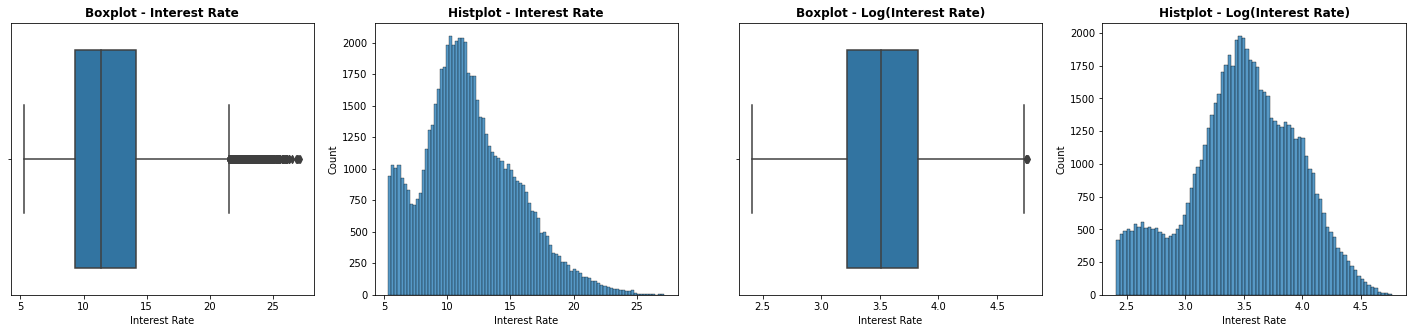

In [14]:
col = 'Interest Rate'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

In [15]:
train['Interest Amount'] = train['Interest Rate'] * train['Loan Amount']
test['Interest Amount'] = test['Interest Rate'] * test['Loan Amount']

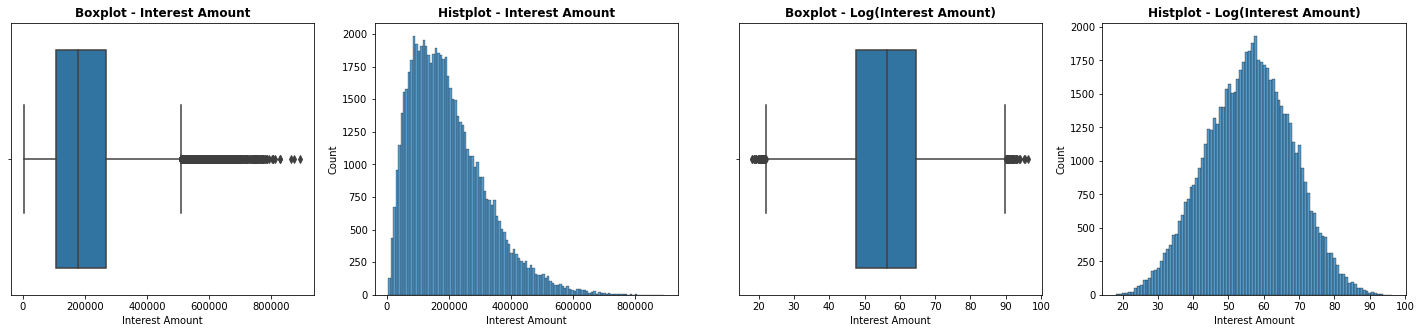

In [16]:
col = 'Interest Amount'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

In [17]:
train['Interest Rate'] = np.log2(train['Interest Rate'])
test['Interest Rate'] = np.log2(test['Interest Rate'])

train['Interest Amount'] = np.cbrt(train['Interest Amount'])
test['Interest Amount'] = np.cbrt(test['Interest Amount'])

### Grade and Sub-Grade

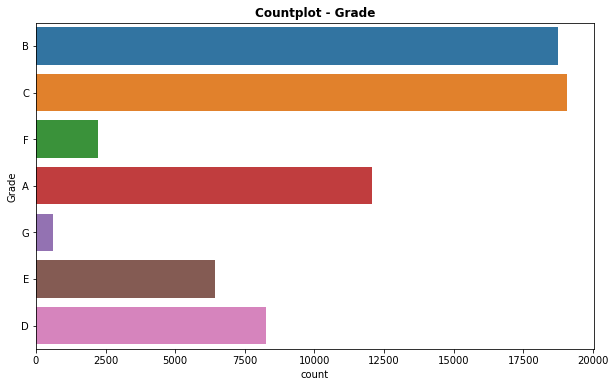

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Grade', data=train)
plt.title("Countplot - Grade", fontweight='bold');

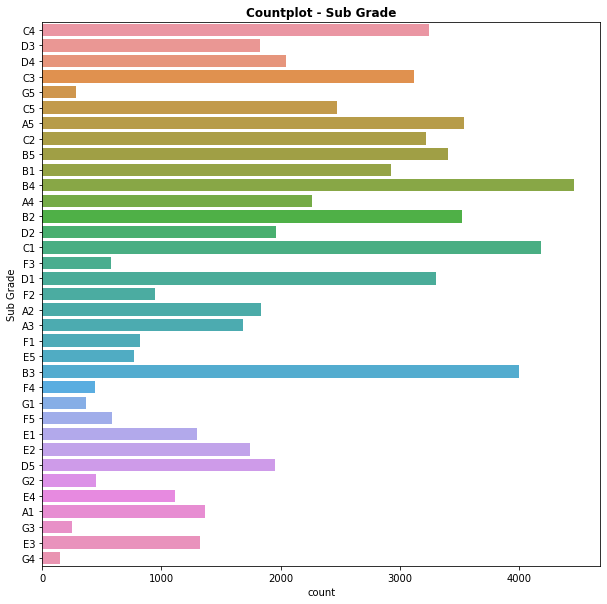

In [19]:
plt.figure(figsize=(10, 10))
sns.countplot(y='Sub Grade', data=train)
plt.title("Countplot - Sub Grade", fontweight='bold');

In [20]:
le = LabelEncoder().fit(train['Grade'].append(test['Grade']))
train['Grade'] = le.transform(train['Grade'])
test['Grade'] = le.transform(test['Grade'])

In [21]:
le = LabelEncoder().fit(train['Sub Grade'].append(test['Sub Grade']))
train['Sub Grade'] = le.transform(train['Sub Grade'])
test['Sub Grade'] = le.transform(test['Sub Grade'])
train.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status,Interest Amount
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,111.037664,59,16,3.477031,1,13,MORTGAGE,176346.62670,...,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0,48.109425
1450153,3609,11940,110.417376,59,4,3.613244,2,17,RENT,39833.92100,...,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0,35.347655
1969101,28276,9311,146.980354,59,11,3.649142,5,18,MORTGAGE,91506.69105,...,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0,70.790190
6651430,11170,6954,133.705482,59,15,4.064469,2,12,MORTGAGE,108286.57590,...,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0,57.173323
14354669,16890,13226,116.361191,59,32,3.907689,2,18,MORTGAGE,44234.82545,...,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0,63.287856


### Employment Duration

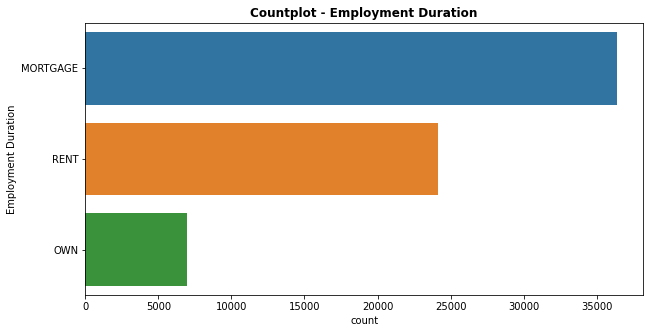

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Employment Duration', data=train)
plt.title("Countplot - Employment Duration", fontweight='bold');

In [23]:
le = LabelEncoder().fit(train['Employment Duration'].append(test['Employment Duration']))
train['Employment Duration'] = le.transform(train['Employment Duration'])
test['Employment Duration'] = le.transform(test['Employment Duration'])
train.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status,Interest Amount
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,111.037664,59,16,3.477031,1,13,0,176346.62670,...,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0,48.109425
1450153,3609,11940,110.417376,59,4,3.613244,2,17,2,39833.92100,...,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0,35.347655
1969101,28276,9311,146.980354,59,11,3.649142,5,18,0,91506.69105,...,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0,70.790190
6651430,11170,6954,133.705482,59,15,4.064469,2,12,0,108286.57590,...,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0,57.173323
14354669,16890,13226,116.361191,59,32,3.907689,2,18,0,44234.82545,...,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0,63.287856


### Home Ownership

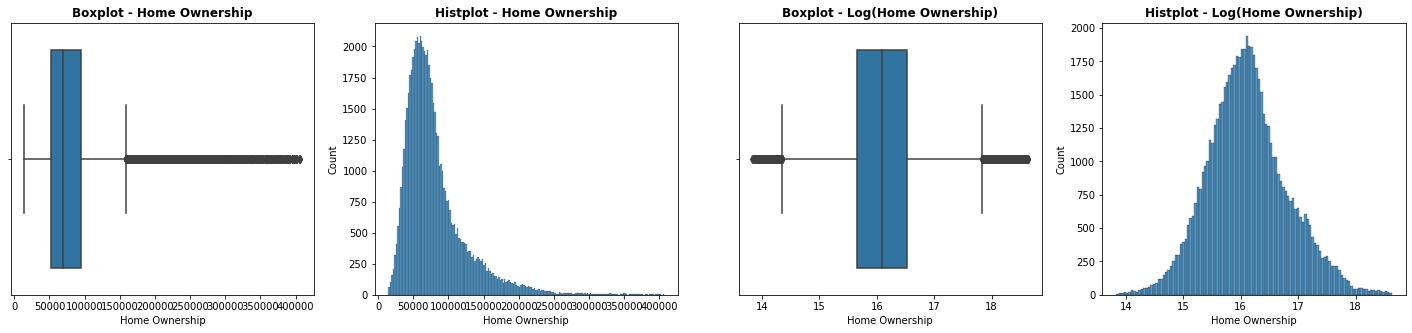

In [24]:
col = 'Home Ownership'
x1 = train[col]
x2 = np.log2(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - Log({col})", fontweight='bold');
ax[3].set_title(f"Histplot - Log({col})", fontweight='bold');

In [25]:
train['Home Ownership'] = np.log2(train['Home Ownership'])
test['Home Ownership'] = np.log2(test['Home Ownership'])

### Verification Status

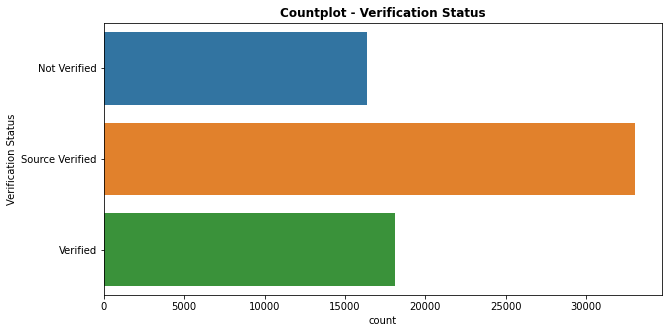

In [26]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Verification Status', data=train)
plt.title("Countplot - Verification Status", fontweight='bold');

In [27]:
le = LabelEncoder().fit(train['Verification Status'].append(test['Verification Status']))
train['Verification Status'] = le.transform(train['Verification Status'])
test['Verification Status'] = le.transform(test['Verification Status'])
train.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status,Interest Amount
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,111.037664,59,16,3.477031,1,13,0,17.428054,...,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0,48.109425
1450153,3609,11940,110.417376,59,4,3.613244,2,17,2,15.281710,...,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0,35.347655
1969101,28276,9311,146.980354,59,11,3.649142,5,18,0,16.481590,...,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0,70.790190
6651430,11170,6954,133.705482,59,15,4.064469,2,12,0,16.724495,...,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0,57.173323
14354669,16890,13226,116.361191,59,32,3.907689,2,18,0,15.432895,...,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0,63.287856


### Loan Title

In [28]:
load_title_dict = {
    'Bathroom': 'Bathroom',
    'Bill Consolidation': 'Bills',
    'Bill Payoff': 'Bills',
    'bills': 'Bills',
    'Business': 'Business',
    'Car financing': 'Car',
    'Car Loan': 'Car',
    'Card Consolidation': 'Cards',
    'cards': 'Cards',
    'Cards': 'Cards',
    'CC': 'CC',
    'CC consolidation': 'CC',
    'CC Consolidation': 'CC',
    'CC Loan': 'CC',
    'CC Refi': 'CC',
    'CC Refinance': 'CC',
    'CC-Refinance': 'CC',
    'conso': 'Consolidate',
    'consolidate': 'Consolidate',
    'Consolidate': 'Consolidate',
    'CONSOLIDATE': 'Consolidate',
    'Consolidated': 'Consolidate',
    'Consolidation': 'Consolidate',
    'consolidation': 'Consolidate',
    'CONSOLIDATION': 'Consolidate',
    'consolidation loan': 'Consolidate',
    'Consolidation Loan': 'Consolidate',
    'Credit': 'Credit Card',
    'credit card': 'Credit Card',
    'Credit Card': 'Credit Card',
    'credit card consolidation': 'Credit Card',
    'Credit Card Consolidation': 'Credit Card',
    'Credit Card consolidation': 'Credit Card',
    'Credit Card Debt': 'Credit Card Debt',
    'Credit Card Loan': 'Credit Card Loan',
    'Credit card pay off': 'Credit Card Payoff',
    'Credit Card Paydown': 'Credit Card Paydown',
    'Credit card payoff': 'Credit Card Payoff',
    'Credit Card Payoff': 'Credit Card Payoff',
    'Credit Card Refi': 'Credit Card Refinance',
    'Credit Card Refinance': 'Credit Card Refinance',
    'credit card refinance': 'Credit Card Refinance',
    'Credit card refinance': 'Credit Card Refinance',
    'Credit Card Refinance Loan': 'Credit Card Refinance',
    'Credit card refinancing': 'Credit Card Refinance',
    'Credit Cards': 'Credit Card',
    'Credit Consolidation': 'Credit Card',
    'Credit Loan': 'Credit Card',
    'credit pay off': 'Credit Card Payoff',
    'Credit payoff': 'Credit Card Payoff',
    'debt': 'Debt Consolidation',
    'Debt': 'Debt Consolidation',
    'Debt Consolidation': 'Debt Consolidation',
    'Debt consolidation': 'Debt Consolidation',
    'DEBT CONSOLIDATION': 'Debt Consolidation',
    'debt consolidation': 'Debt Consolidation',
    'Debt Consolidation 2013': 'Debt Consolidation',
    'Debt Consolidation Loan': 'Debt Consolidation',
    'debt consolidation loan': 'Debt Consolidation',
    'Debt Free': 'Debt Free',
    'debt loan': 'Debt Loan',
    'Debt Loan': 'Debt Loan',
    'Debt Payoff': 'Debt Payoff',
    'Debt payoff': 'Debt Payoff',
    'Debt Reduction': 'Debt Reduction',
    'Dept consolidation': 'Debt Consolidation',
    'Freedom': 'Freedom',
    'Get Debt Free': 'Get Debt Free',
    'get out of debt': 'get out of debt',
    'Getting Ahead': 'Getting Ahead',
    'Green loan': 'Green loan',
    'Home': 'Home',
    'Home buying': 'Home',
    'Home improvement': 'Home',
    'Home Improvement': 'Home',
    'home improvement': 'Home',
    'Home Improvement Loan': 'Home',
    'Home loan': 'Home',
    'House': 'Home',
    'Lending Club': 'Lending Club',
    'Lending loan': 'Lending loan',
    'Loan': 'Loan',
    'Loan 1': 'Loan',
    'Loan Consolidation': 'Loan',
    'loan1': 'Loan',
    'Major purchase': 'Major purchase',
    'Medical': 'Medical',
    'Medical expenses': 'Medical',
    'Medical loan': 'Medical',
    'Moving and relocation': 'Moving and relocation',
    'My Loan': 'My Loan',
    'MYLOAN': 'My Loan',
    'Other': 'Other',
    'Pay Off': 'Pay Off',
    'pay off bills': 'Pay Off',
    'payoff': 'Pay Off',
    'Payoff': 'Pay Off',
    'Personal': 'Personal',
    'personal': 'Personal',
    'Personal Loan': 'Personal',
    'Personal loan': 'Personal',
    'Pool': 'Pool',
    'refi': 'Refinance',
    'Refinance': 'Refinance',
    'Refinance Loan': 'Refinance',
    'relief': 'relief',
    'Vacation': 'Vacation',
    'vacation': 'Vacation',
    'Wedding Loan': 'Wedding Loan'
}

train['Loan Title'] = train['Loan Title'].map(load_title_dict)
test['Loan Title'] = test['Loan Title'].map(load_title_dict)

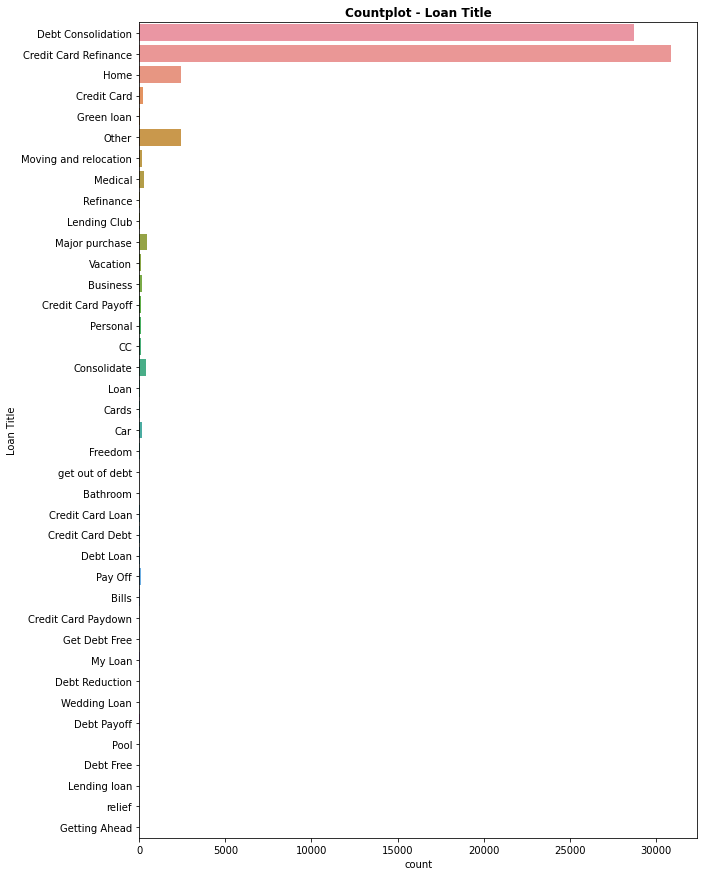

In [29]:
plt.figure(figsize=(10, 15))
sns.countplot(y='Loan Title', data=train)
plt.title("Countplot - Loan Title", fontweight='bold');

In [30]:
le = LabelEncoder().fit(train['Loan Title'].append(test['Loan Title']))
train['Loan Title'] = le.transform(train['Loan Title'])
test['Loan Title'] = le.transform(test['Loan Title'])
train.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status,Interest Amount
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,111.037664,59,16,3.477031,1,13,0,17.428054,...,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0,48.109425
1450153,3609,11940,110.417376,59,4,3.613244,2,17,2,15.281710,...,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0,35.347655
1969101,28276,9311,146.980354,59,11,3.649142,5,18,0,16.481590,...,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0,70.790190
6651430,11170,6954,133.705482,59,15,4.064469,2,12,0,16.724495,...,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0,57.173323
14354669,16890,13226,116.361191,59,32,3.907689,2,18,0,15.432895,...,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0,63.287856


### Debit to Income

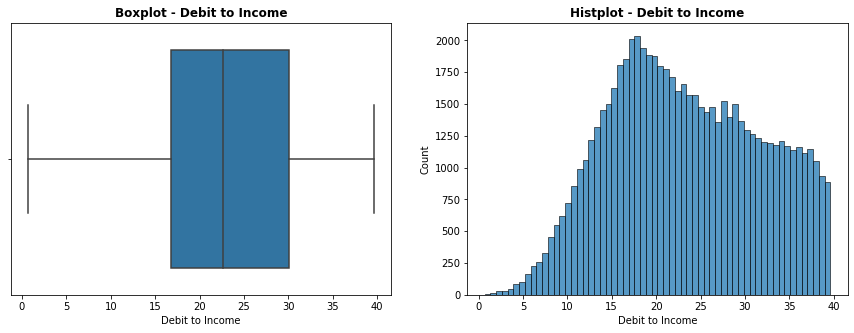

In [31]:
col = 'Debit to Income'
x1 = train[col]

_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');

### Revolving Balance

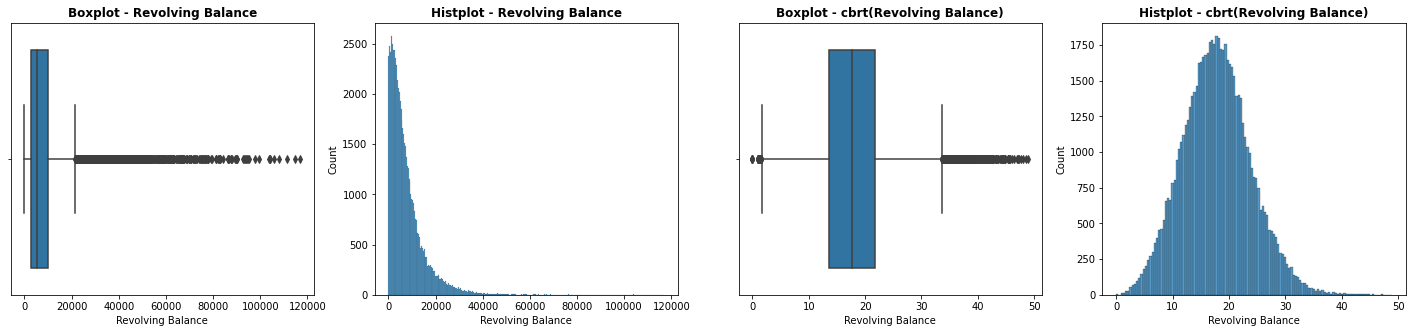

In [32]:
col = 'Revolving Balance'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [33]:
train['Revolving Balance'] = np.cbrt(train['Revolving Balance'])
test['Revolving Balance'] = np.cbrt(test['Revolving Balance'])

### Revolving Utilities

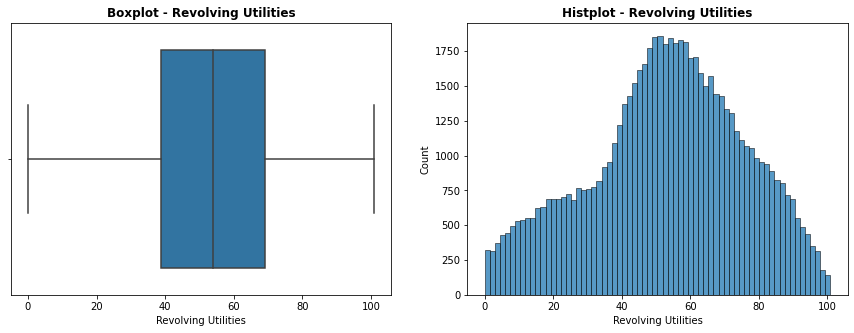

In [34]:
col = 'Revolving Utilities'
x1 = train[col]

_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');

### Initial List Status

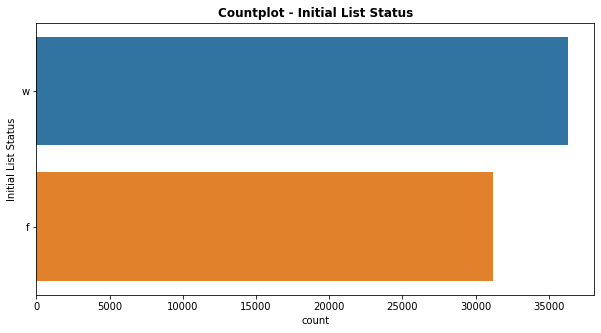

In [35]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Initial List Status', data=train)
plt.title("Countplot - Initial List Status", fontweight='bold');

In [36]:
train['Initial List Status'] = train['Initial List Status'].map({'f':0, 'w':1})
test['Initial List Status'] = test['Initial List Status'].map({'f':0, 'w':1})

### Total Received Interest

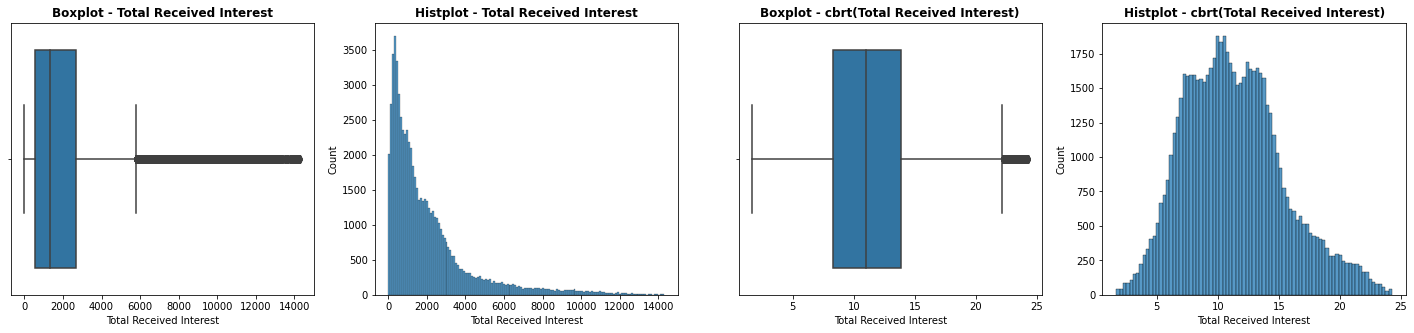

In [37]:
col = 'Total Received Interest'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [38]:
train['Total Received Interest'] = np.cbrt(train['Total Received Interest'])
test['Total Received Interest'] = np.cbrt(test['Total Received Interest'])

### Total Received Late Fee

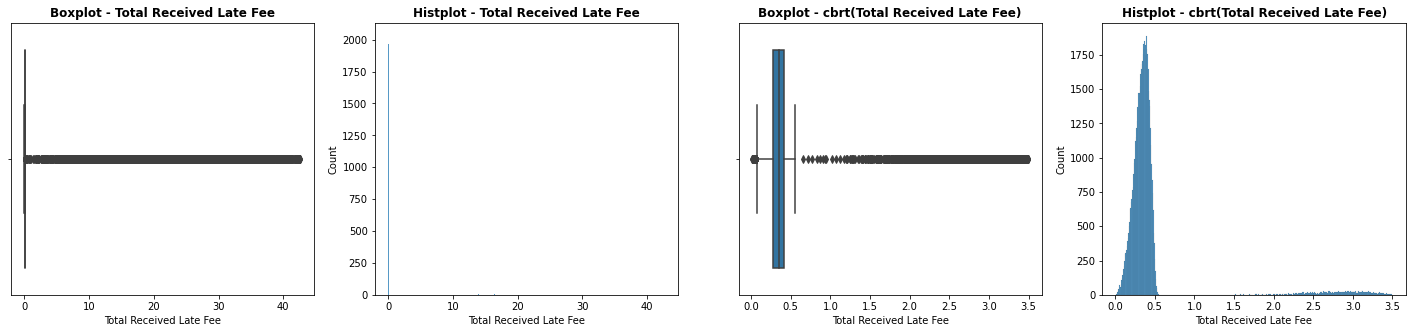

In [39]:
col = 'Total Received Late Fee'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [40]:
train['Total Received Late Fee'] = np.cbrt(train['Total Received Late Fee'])
test['Total Received Late Fee'] = np.cbrt(test['Total Received Late Fee'])

### Recoveries

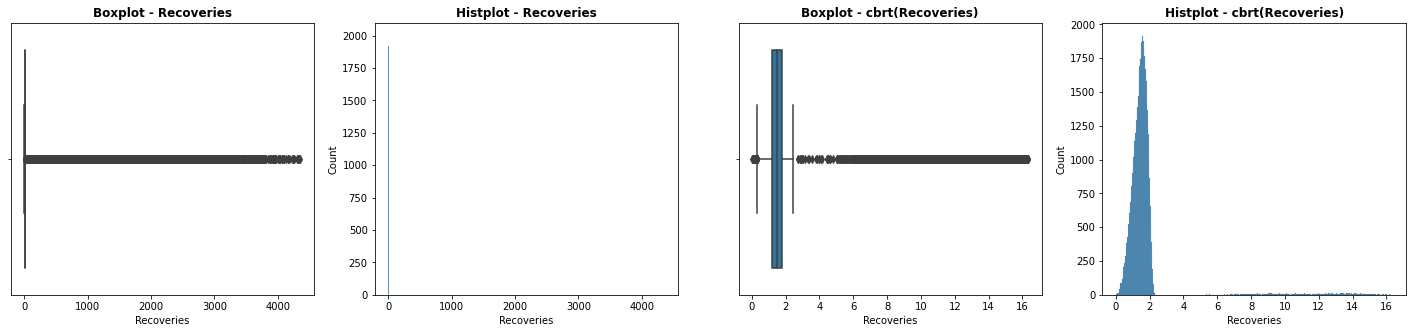

In [41]:
col = 'Recoveries'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [42]:
train['Recoveries'] = np.cbrt(train['Recoveries'])
test['Recoveries'] = np.cbrt(test['Recoveries'])

### Collection Recovery Fee

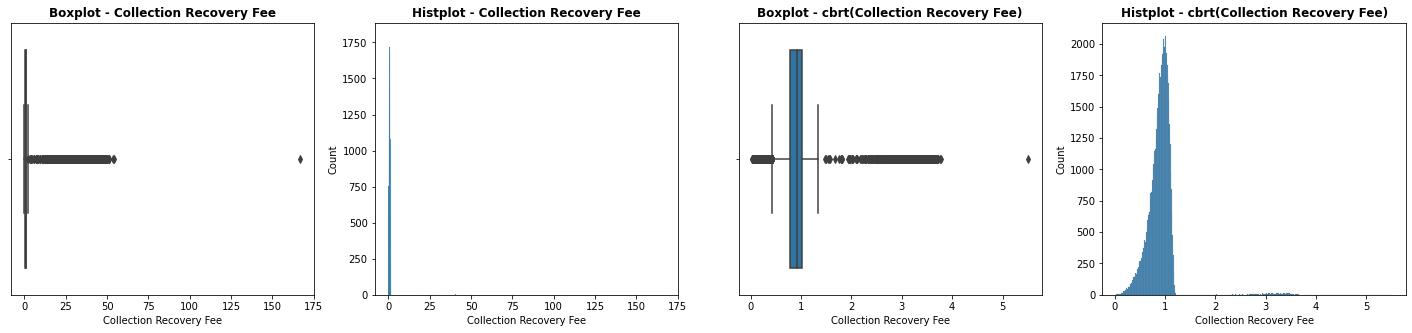

In [43]:
col = 'Collection Recovery Fee'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [44]:
train['Collection Recovery Fee'] = np.cbrt(train['Collection Recovery Fee'])
test['Collection Recovery Fee'] = np.cbrt(test['Collection Recovery Fee'])

### Collection 12 months Medical

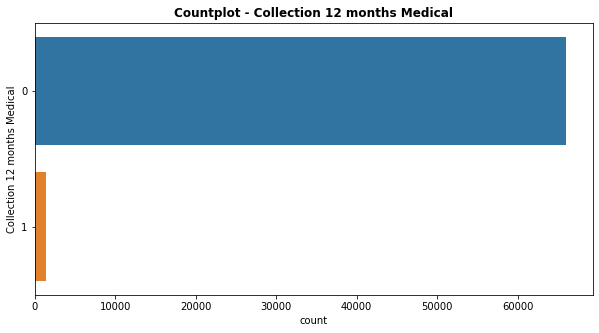

In [45]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Collection 12 months Medical', data=train)
plt.title("Countplot - Collection 12 months Medical", fontweight='bold');

### Application Type

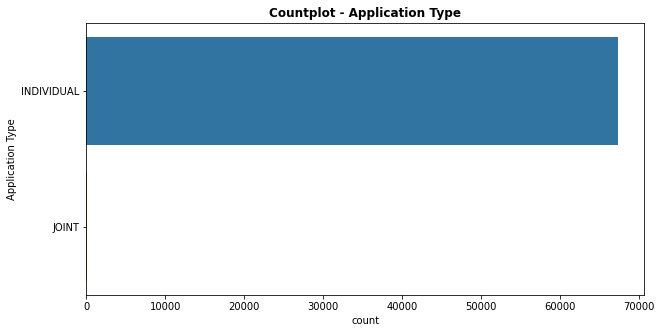

In [46]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Application Type', data=train)
plt.title("Countplot - Application Type", fontweight='bold');

In [47]:
train['Application Type'] = train['Application Type'].map({'INDIVIDUAL':0, 'JOINT':1})
test['Application Type'] = test['Application Type'].map({'INDIVIDUAL':0, 'JOINT':1})

### Total Collection Amount

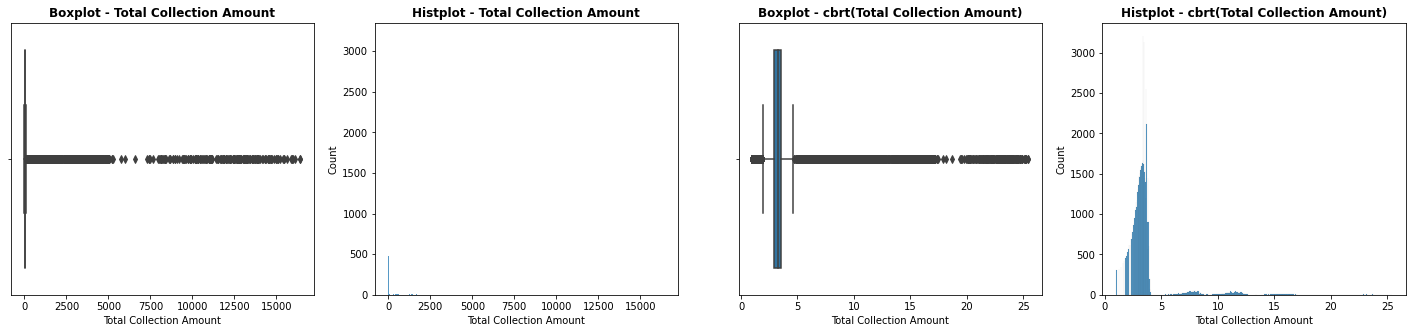

In [48]:
col = 'Total Collection Amount'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [49]:
train['Total Collection Amount'] = np.cbrt(train['Total Collection Amount'])
test['Total Collection Amount'] = np.cbrt(test['Total Collection Amount'])

### Total Current Balance

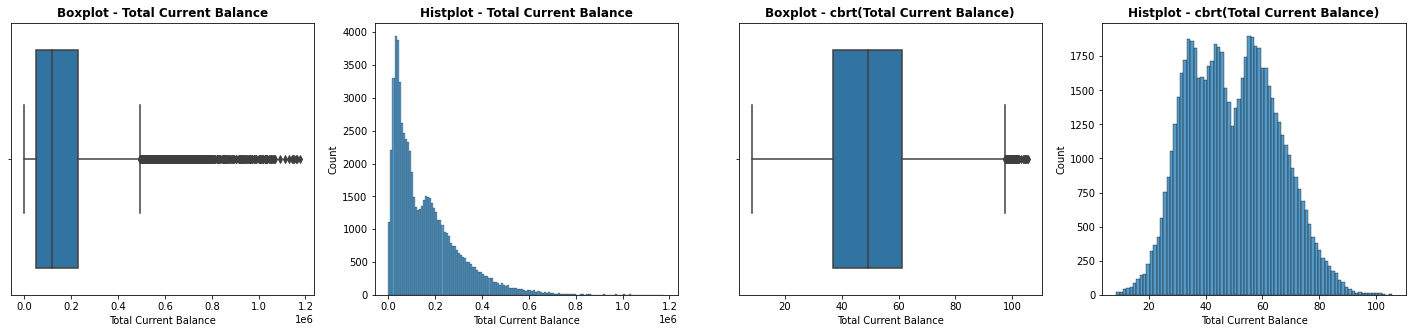

In [50]:
col = 'Total Current Balance'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [51]:
train['Total Current Balance'] = np.cbrt(train['Total Current Balance'])
test['Total Current Balance'] = np.cbrt(test['Total Current Balance'])

### Total Revolving Credit Limit

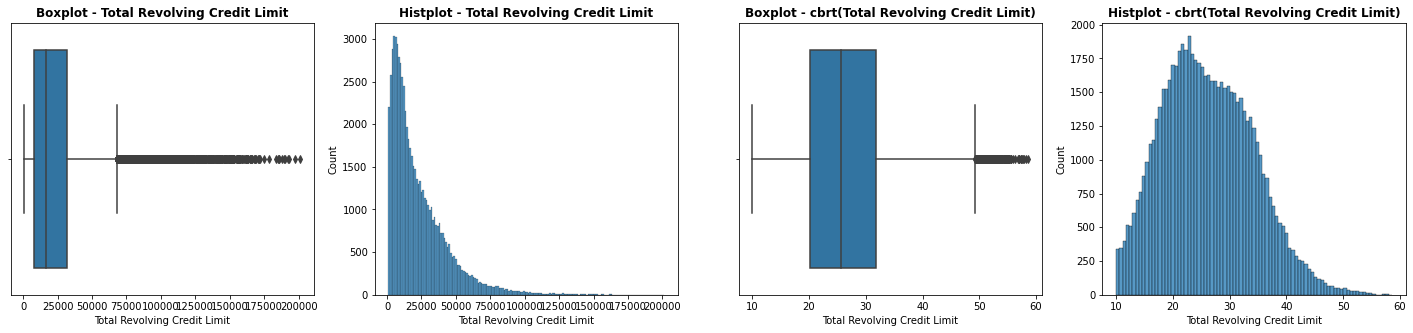

In [52]:
col = 'Total Revolving Credit Limit'
x1 = train[col]
x2 = np.cbrt(x1)

_, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title(f"Boxplot - {col}", fontweight='bold');
ax[1].set_title(f"Histplot - {col}", fontweight='bold');
ax[2].set_title(f"Boxplot - cbrt({col})", fontweight='bold');
ax[3].set_title(f"Histplot - cbrt({col})", fontweight='bold');

In [53]:
train['Total Revolving Credit Limit'] = np.cbrt(train['Total Revolving Credit Limit'])
test['Total Revolving Credit Limit'] = np.cbrt(test['Total Revolving Credit Limit'])

## Features Correlation

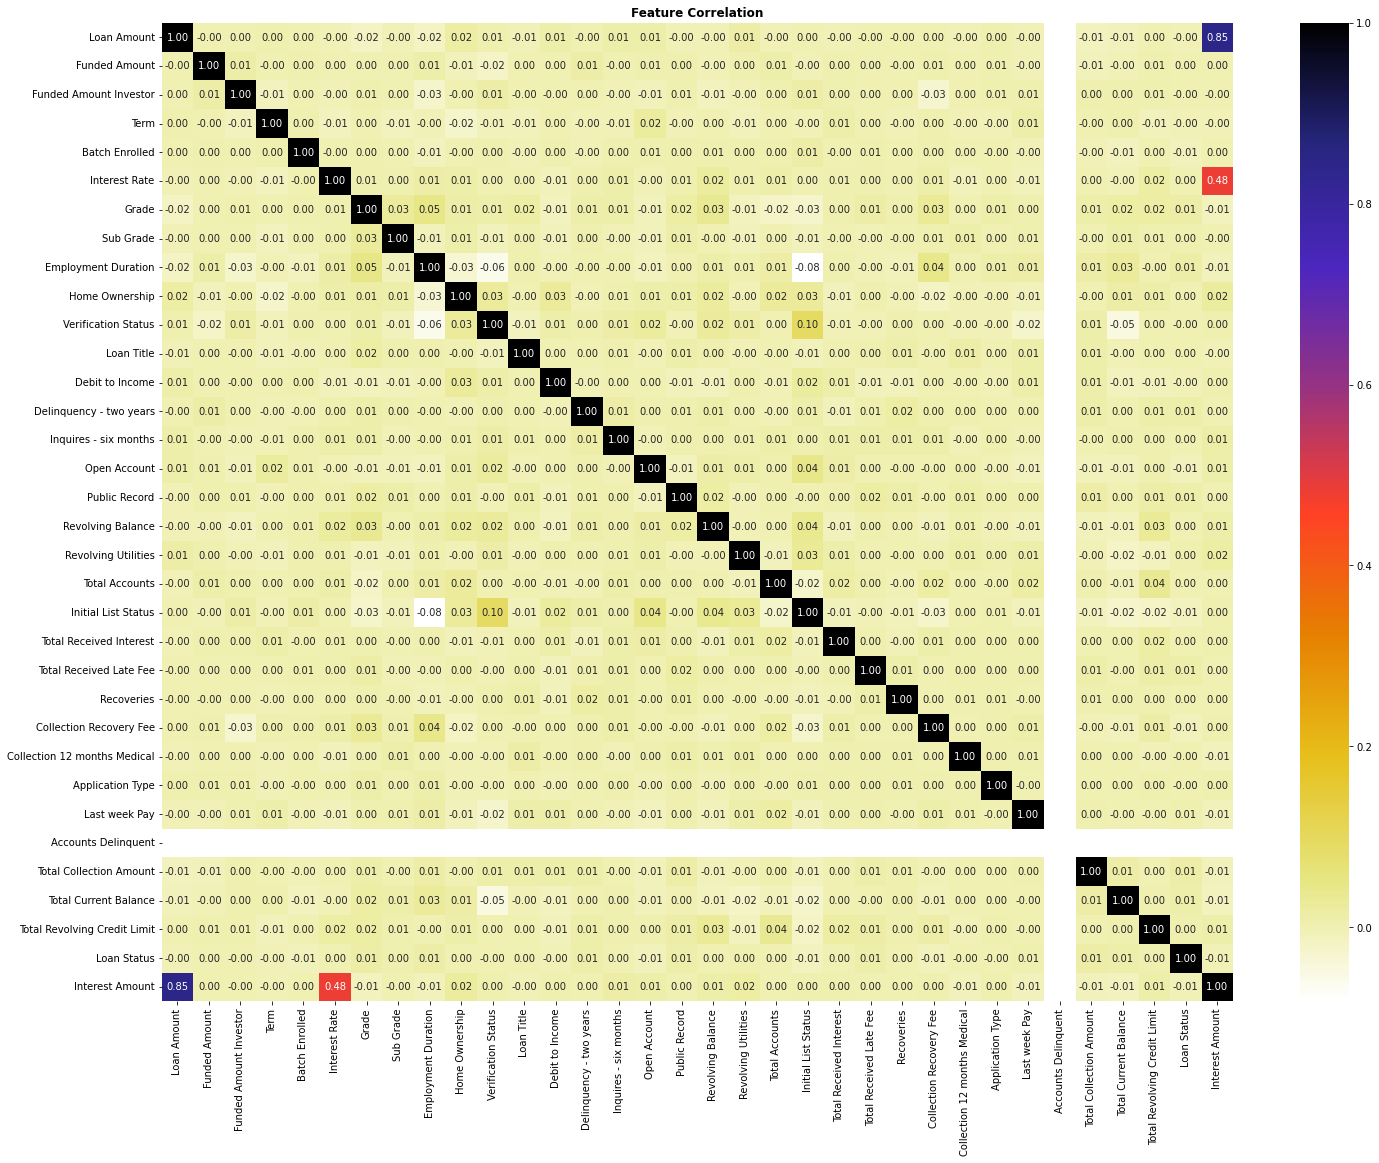

In [54]:
plt.subplots(1,1,figsize=(24, 18))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap="CMRmap_r")
plt.title("Feature Correlation", fontweight='bold');

## Feature Engineering

In [55]:
train_y = train['Loan Status'].copy()
train.drop(['Payment Plan','Accounts Delinquent','Loan Status'], axis=1, inplace=True)
test.drop(['Payment Plan','Accounts Delinquent','Loan Status'], axis=1, inplace=True)

In [56]:
cat_cols = [
    'Batch Enrolled',
    'Grade',
    'Sub Grade',
    'Employment Duration',
    'Verification Status',
    'Loan Title',
    'Delinquency - two years',
    'Inquires - six months',
    'Open Account',
    'Public Record',
    'Initial List Status',
    'Collection 12 months Medical',
    'Application Type'
]

num_cols = [col for col in test.columns if col not in cat_cols]
num_cols.append('ID')
len(cat_cols), len(num_cols)

(13, 20)

In [57]:
combined_df = train.append(test, sort=False, ignore_index=False)
combined_df.reset_index(inplace=True)
print(f"combined_df: {combined_df.shape}")
combined_df.head()

combined_df: (96376, 33)


,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Interest Amount
0,65087372,10000,32236,111.037664,59,16,3.477031,1,13,0,...,0.467317,1.356899,0.925884,0,0,49,3.141381,67.773540,18.775757,48.109425
1,1450153,3609,11940,110.417376,59,4,3.613244,2,17,2,...,0.330746,1.334615,0.991536,0,0,109,3.756286,56.733754,27.538788,35.347655
2,1969101,28276,9311,146.980354,59,11,3.649142,5,18,0,...,2.657999,1.628183,1.006647,0,0,66,3.239612,44.780993,29.683714,70.790190
3,6651430,11170,6954,133.705482,59,15,4.064469,2,12,0,...,0.353386,0.474776,0.908549,0,0,39,3.419952,20.945437,39.195165,57.173323
4,14354669,16890,13226,116.361191,59,32,3.907689,2,18,0,...,2.682680,10.899410,0.717228,0,0,18,7.547842,50.136825,28.264083,63.287856


In [58]:
feature_df = combined_df[num_cols]
feature_df.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Debit to Income,Revolving Balance,Revolving Utilities,Total Accounts,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Interest Amount,ID
0,10000,32236,111.037664,59,3.477031,17.428054,16.284758,28.943210,74.932551,7,14.308861,0.467317,1.356899,0.925884,49,3.141381,67.773540,18.775757,48.109425,65087372
1,3609,11940,110.417376,59,3.613244,15.281710,15.412409,9.329363,78.297186,13,9.176632,0.330746,1.334615,0.991536,109,3.756286,56.733754,27.538788,35.347655,1450153
2,28276,9311,146.980354,59,3.649142,16.481590,28.137619,12.260507,2.073040,20,9.521923,2.657999,1.628183,1.006647,66,3.239612,44.780993,29.683714,70.790190,1969101
3,11170,6954,133.705482,59,4.064469,16.724495,18.043730,23.997106,67.467951,12,6.605178,0.353386,0.474776,0.908549,39,3.419952,20.945437,39.195165,57.173323,6651430
4,16890,13226,116.361191,59,3.907689,15.432895,17.209886,11.557993,85.250761,22,5.055900,2.682680,10.899410,0.717228,18,7.547842,50.136825,28.264083,63.287856,14354669


In [59]:
es = ft.EntitySet(id='Deloitte')
es = es.add_dataframe(
    dataframe_name="feature_df",
    dataframe=feature_df,
    index="ID"
)

feature_matrix, feature_names = ft.dfs(entityset=es, target_dataframe_name='feature_df', 
                                       trans_primitives=['divide_numeric'],
                                       max_depth=2, verbose=3, n_jobs=1)

feature_matrix.drop(['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term', 
                     'Interest Rate', 'Home Ownership', 'Debit to Income', 'Revolving Balance', 
                     'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 
                     'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 
                     'Last week Pay', 'Total Collection Amount', 'Total Current Balance', 
                     'Total Revolving Credit Limit', 'Interest Amount'], 
                     axis=1, inplace=True)

feature_matrix.fillna(0, inplace=True)
feature_matrix.head()

Built 361 features
Elapsed: 00:00 | Progress:  87%|████████▋ 

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4486: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[k] = com.apply_if_callable(v, data)


Elapsed: 00:03 | Progress: 100%|██████████


,Collection Recovery Fee / Debit to Income,Collection Recovery Fee / Funded Amount,Collection Recovery Fee / Funded Amount Investor,Collection Recovery Fee / Home Ownership,Collection Recovery Fee / Interest Amount,Collection Recovery Fee / Interest Rate,Collection Recovery Fee / Last week Pay,Collection Recovery Fee / Loan Amount,Collection Recovery Fee / Recoveries,Collection Recovery Fee / Revolving Balance,...,Total Revolving Credit Limit / Loan Amount,Total Revolving Credit Limit / Recoveries,Total Revolving Credit Limit / Revolving Balance,Total Revolving Credit Limit / Revolving Utilities,Total Revolving Credit Limit / Term,Total Revolving Credit Limit / Total Accounts,Total Revolving Credit Limit / Total Collection Amount,Total Revolving Credit Limit / Total Current Balance,Total Revolving Credit Limit / Total Received Interest,Total Revolving Credit Limit / Total Received Late Fee
ID,,,,,,,,,,,,,,,,,,,,,
65087372,0.056856,0.000029,0.008338,0.053126,0.019245,0.266286,0.018896,0.000093,0.682353,0.031990,...,0.001878,13.837250,0.648710,0.250569,0.318233,2.682251,5.976912,0.277037,1.312177,40.177763
1450153,0.064334,0.000083,0.008980,0.064884,0.028051,0.274417,0.009097,0.000275,0.742937,0.106281,...,0.007631,20.634250,2.951840,0.351721,0.466759,2.118368,7.331388,0.485404,3.000969,83.262726
1969101,0.035776,0.000108,0.006849,0.061077,0.014220,0.275859,0.015252,0.000036,0.618264,0.082105,...,0.001050,18.231195,2.421084,14.318931,0.503114,1.484186,9.162738,0.662864,3.117407,11.167691
6651430,0.050353,0.000131,0.006795,0.054324,0.015891,0.223534,0.023296,0.000081,1.913637,0.037861,...,0.003509,82.555079,1.633329,0.580945,0.664325,3.266264,11.460736,1.871299,5.934006,110.913228
14354669,0.041675,0.000054,0.006164,0.046474,0.011333,0.183543,0.039846,0.000042,0.065804,0.062055,...,0.001673,2.593175,2.445414,0.331541,0.479052,1.284731,3.744657,0.563739,5.590317,10.535762


In [60]:
inf_cols = feature_matrix.columns.to_series()[np.isinf(feature_matrix).any()].reset_index(name='Column')['Column'].tolist()
len(inf_cols)

122

In [61]:
feature_matrix.drop(inf_cols, axis=1, inplace=True)
print(f"feature_matrix: {feature_matrix.shape}")
feature_matrix.head()

feature_matrix: (96376, 220)


,Collection Recovery Fee / Debit to Income,Collection Recovery Fee / Funded Amount,Collection Recovery Fee / Funded Amount Investor,Collection Recovery Fee / Home Ownership,Collection Recovery Fee / Interest Amount,Collection Recovery Fee / Interest Rate,Collection Recovery Fee / Loan Amount,Collection Recovery Fee / Recoveries,Collection Recovery Fee / Revolving Utilities,Collection Recovery Fee / Term,...,Total Revolving Credit Limit / Funded Amount,Total Revolving Credit Limit / Funded Amount Investor,Total Revolving Credit Limit / Home Ownership,Total Revolving Credit Limit / Interest Amount,Total Revolving Credit Limit / Interest Rate,Total Revolving Credit Limit / Loan Amount,Total Revolving Credit Limit / Term,Total Revolving Credit Limit / Total Accounts,Total Revolving Credit Limit / Total Current Balance,Total Revolving Credit Limit / Total Received Interest
ID,,,,,,,,,,,,,,,,,,,,,
65087372,0.056856,0.000029,0.008338,0.053126,0.019245,0.266286,0.000093,0.682353,0.012356,0.015693,...,0.000582,0.169094,1.077330,0.390272,5.399940,0.001878,0.318233,2.682251,0.277037,1.312177
1450153,0.064334,0.000083,0.008980,0.064884,0.028051,0.274417,0.000275,0.742937,0.012664,0.016806,...,0.002306,0.249406,1.802075,0.779084,7.621624,0.007631,0.466759,2.118368,0.485404,3.000969
1969101,0.035776,0.000108,0.006849,0.061077,0.014220,0.275859,0.000036,0.618264,0.485590,0.017062,...,0.003188,0.201957,1.801023,0.419320,8.134436,0.001050,0.503114,1.484186,0.662864,3.117407
6651430,0.050353,0.000131,0.006795,0.054324,0.015891,0.223534,0.000081,1.913637,0.013466,0.015399,...,0.005636,0.293146,2.343578,0.685550,9.643366,0.003509,0.664325,3.266264,1.871299,5.934006
14354669,0.041675,0.000054,0.006164,0.046474,0.011333,0.183543,0.000042,0.065804,0.008413,0.012156,...,0.002137,0.242900,1.831418,0.446596,7.232941,0.001673,0.479052,1.284731,0.563739,5.590317


In [62]:
combined_df.set_index('ID', inplace=True)

combined_df = pd.merge(
    combined_df, 
    feature_matrix, 
    how='inner', 
    on='ID', 
    sort=False, 
    suffixes=('_x', '_y')
)
combined_df.head()

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,...,Total Revolving Credit Limit / Funded Amount,Total Revolving Credit Limit / Funded Amount Investor,Total Revolving Credit Limit / Home Ownership,Total Revolving Credit Limit / Interest Amount,Total Revolving Credit Limit / Interest Rate,Total Revolving Credit Limit / Loan Amount,Total Revolving Credit Limit / Term,Total Revolving Credit Limit / Total Accounts,Total Revolving Credit Limit / Total Current Balance,Total Revolving Credit Limit / Total Received Interest
ID,,,,,,,,,,,,,,,,,,,,,
65087372,10000,32236,111.037664,59,16,3.477031,1,13,0,17.428054,...,0.000582,0.169094,1.077330,0.390272,5.399940,0.001878,0.318233,2.682251,0.277037,1.312177
1450153,3609,11940,110.417376,59,4,3.613244,2,17,2,15.281710,...,0.002306,0.249406,1.802075,0.779084,7.621624,0.007631,0.466759,2.118368,0.485404,3.000969
1969101,28276,9311,146.980354,59,11,3.649142,5,18,0,16.481590,...,0.003188,0.201957,1.801023,0.419320,8.134436,0.001050,0.503114,1.484186,0.662864,3.117407
6651430,11170,6954,133.705482,59,15,4.064469,2,12,0,16.724495,...,0.005636,0.293146,2.343578,0.685550,9.643366,0.003509,0.664325,3.266264,1.871299,5.934006
14354669,16890,13226,116.361191,59,32,3.907689,2,18,0,15.432895,...,0.002137,0.242900,1.831418,0.446596,7.232941,0.001673,0.479052,1.284731,0.563739,5.590317


In [63]:
train = combined_df[:train_y.shape[0]].copy()
test = combined_df[train_y.shape[0]:].copy()
print(f"train: {train.shape} \ntest: {test.shape}")

train: (67463, 252) 
test: (28913, 252)


## Feature Scaling

In [64]:
cat_cols = [
    'Batch Enrolled',
    'Grade',
    'Sub Grade',
    'Employment Duration',
    'Verification Status',
    'Loan Title',
    'Delinquency - two years',
    'Inquires - six months',
    'Open Account',
    'Public Record',
    'Initial List Status',
    'Collection 12 months Medical',
    'Application Type'
]

num_cols = [col for col in test.columns if col not in cat_cols]
len(cat_cols), len(num_cols)

(13, 239)

In [65]:
scaler = MinMaxScaler().fit(train[num_cols])
train[num_cols] = scaler.transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

## K-Means

100%|██████████| 9/9 [03:23<00:00, 22.65s/it]


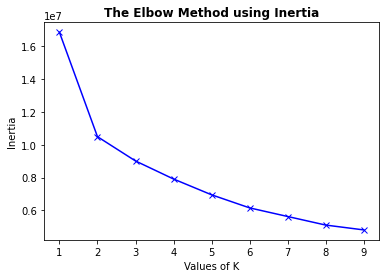

In [66]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k).fit(train)
    kmeanModel.fit(train)
 
    distortions.append(sum(np.min(cdist(train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / train.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / train.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia', fontweight='bold')
plt.show()

In [67]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)

kmeans.fit(train)
pred = kmeans.predict(train)
train['cluster'] = pred
train['Loan Status'] = train_y.values

pred = kmeans.predict(test)
test['cluster'] = pred

cat_cols.append('cluster')

In [68]:
Xtrain = train.loc[:, ~train.columns.isin(['Loan Status'])].copy()
Ytrain = train['Loan Status'].copy()
Xtest = test.copy()

print("Xtrain: {} \nYtrain: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape))

Xtrain: (67463, 253) 
Ytrain: (67463,) 
Xtest: (28913, 253)


In [69]:
train[cat_cols] = Xtrain[cat_cols].astype(int)
test[cat_cols] = Xtest[cat_cols].astype(int)
cat_cols_indices = [Xtrain.columns.get_loc(col) for col in cat_cols]
print(cat_cols_indices)

[4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 20, 25, 26, 252]


## LightGBM

In [70]:
params = {}
params["objective"] = 'multiclass'
params["metric"] = 'multi_logloss'
params["num_class"] = 2
params["is_unbalance"] = True
params["boosting"] = 'gbdt'
params["learning_rate"] = 0.08242
params["lambda_l1"] = 7.53
params["lambda_l2"] = 0.0074
params["num_leaves"] = 1032
params["max_depth"] = 6
params["feature_fraction"] = 0.3496
params["bagging_fraction"] = 0.7791
params["bagging_freq"] = 1
params["min_data_in_leaf"] = 16
params["bagging_seed"] = 42
params["random_seed"] = 42
params["verbosity"] = -1
num_rounds = 5000

In [71]:
FOLD = 5
SEEDS = [17, 23]

oof_score = 0
y_pred_meta_lgb1 = np.zeros((Xtrain.shape[0], 1))
y_pred_final_lgb1 = np.zeros((Xtest.shape[0], 1))
counter = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
        counter += 1

        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]

        lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
        lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

        model = lgb.train(params, lgtrain, num_rounds, 
                          valid_sets=[lgtrain, lgvalidation], 
                          categorical_feature=cat_cols_indices,
                          early_stopping_rounds=200, verbose_eval=200)

        y_pred = model.predict(val_x, num_iteration=model.best_iteration)[:,-1]
        y_pred_meta_lgb1[val] += np.array([y_pred]).T
        y_pred_final_lgb1 += np.array([model.predict(Xtest, num_iteration=model.best_iteration)[:,-1]]).T
        
        score = log_loss(val_y, y_pred)
        oof_score += score
        seed_score += score
        print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_lgb1 = y_pred_meta_lgb1 / float(len(SEEDS))
y_pred_final_lgb1 = y_pred_final_lgb1 / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.216745	valid_1's multi_logloss: 0.312347
Early stopping, best iteration is:
[6]	training's multi_logloss: 0.303912	valid_1's multi_logloss: 0.307945

Seed-17 | Fold-0 | OOF Score: 0.30794544244603744

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.21541	valid_1's multi_logloss: 0.314236
Early stopping, best iteration is:
[9]	training's multi_logloss: 0.302	valid_1's multi_logloss: 0.308064

Seed-17 | Fold-1 | OOF Score: 0.30806426734071557

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.216919	valid_1's multi_logloss: 0.311124
Early stopping, best iteration is:
[28]	training's multi_logloss: 0.291202	valid_1's multi_logloss: 0.30748

Seed-17 | Fold-2 | OOF Score: 0.3074804643377068

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.215859	valid_1's m

In [72]:
params = {}
params["objective"] = 'multiclass'
params["metric"] = 'multi_logloss'
params["num_class"] = 2
params["is_unbalance"] = True
params["boosting"] = 'gbdt'
params["learning_rate"] = 0.00562
params["lambda_l1"] = 0.05325
params["lambda_l2"] = 1.43018
params["num_leaves"] = 864
params["max_depth"] = 5
params["feature_fraction"] = 0.2925
params["bagging_fraction"] = 0.7067
params["bagging_freq"] = 3
params["min_data_in_leaf"] = 2
params["bagging_seed"] = 42
params["random_seed"] = 42
params["verbosity"] = -1
num_rounds = 5000

In [73]:
FOLD = 5
SEEDS = [37, 43]

oof_score = 0
y_pred_meta_lgb2 = np.zeros((Xtrain.shape[0], 1))
y_pred_final_lgb2 = np.zeros((Xtest.shape[0], 1))
counter = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
        counter += 1

        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]

        lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
        lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

        model = lgb.train(params, lgtrain, num_rounds, 
                          valid_sets=[lgtrain, lgvalidation], 
                          categorical_feature=cat_cols_indices,
                          early_stopping_rounds=200, verbose_eval=200)

        y_pred = model.predict(val_x, num_iteration=model.best_iteration)[:,-1]
        y_pred_meta_lgb2[val] += np.array([y_pred]).T
        y_pred_final_lgb2 += np.array([model.predict(Xtest, num_iteration=model.best_iteration)[:,-1]]).T
        
        score = log_loss(val_y, y_pred)
        oof_score += score
        seed_score += score
        print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_lgb2 = y_pred_meta_lgb2 / float(len(SEEDS))
y_pred_final_lgb2 = y_pred_final_lgb2 / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.300458	valid_1's multi_logloss: 0.307882
[400]	training's multi_logloss: 0.293768	valid_1's multi_logloss: 0.307988
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.30028	valid_1's multi_logloss: 0.30787

Seed-37 | Fold-0 | OOF Score: 0.30786987843063546

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.300584	valid_1's multi_logloss: 0.308033
[400]	training's multi_logloss: 0.294041	valid_1's multi_logloss: 0.30811
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.300415	valid_1's multi_logloss: 0.308022

Seed-37 | Fold-1 | OOF Score: 0.3080216328442689

Training until validation scores don't improve for 200 rounds
[200]	training's multi_logloss: 0.30085	valid_1's multi_logloss: 0.307804
[400]	training's multi_logloss: 0.294379	valid_1's multi_logloss: 0.30762
[600]	training's multi_logloss: 0.288536	valid

## CatBoost

In [74]:
FOLD = 5
SEEDS = [17, 23]

oof_score = 0
y_pred_meta_cb1 = np.zeros((Xtrain.shape[0], 1))
y_pred_final_cb1 = np.zeros((Xtest.shape[0], 1))
counter = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
        counter += 1

        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]

        model = CatBoostClassifier(
            objective='MultiClass',
            eval_metric='MultiClass',
            num_boost_round=5000,
            learning_rate=0.00986,
            reg_lambda=0.15953,
            use_best_model=True,
            bootstrap_type='Bernoulli',
            subsample=0.91614,
            max_depth=5, 
            grow_policy='Lossguide',
            min_data_in_leaf=5, 
            max_leaves=625,
            task_type='CPU',
            random_seed=42,
            verbose=0
        )

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
                  cat_features=cat_cols_indices,
                  early_stopping_rounds=200, verbose=200)

        y_pred = model.predict_proba(val_x)[:,-1]
        y_pred_meta_cb1[val] += np.array([y_pred]).T
        y_pred_final_cb1 += np.array([model.predict_proba(Xtest)[:,-1]]).T
        
        score = log_loss(val_y, y_pred)
        oof_score += score
        seed_score += score
        print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_cb1 = y_pred_meta_cb1 / float(len(SEEDS))
y_pred_final_cb1 = y_pred_final_cb1 / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

0:	learn: 0.6866297	test: 0.6866339	best: 0.6866339 (0)	total: 331ms	remaining: 27m 33s
200:	learn: 0.3212506	test: 0.3221174	best: 0.3221174 (200)	total: 51.9s	remaining: 20m 38s
400:	learn: 0.3035726	test: 0.3082281	best: 0.3082281 (400)	total: 1m 44s	remaining: 20m
600:	learn: 0.2976294	test: 0.3076216	best: 0.3076216 (600)	total: 2m 35s	remaining: 18m 59s
800:	learn: 0.2928578	test: 0.3075786	best: 0.3075681 (799)	total: 3m 25s	remaining: 17m 59s
1000:	learn: 0.2881300	test: 0.3075690	best: 0.3075418 (864)	total: 4m 16s	remaining: 17m 3s
1200:	learn: 0.2832188	test: 0.3075025	best: 0.3074759 (1145)	total: 5m 4s	remaining: 16m 2s
1400:	learn: 0.2779560	test: 0.3074998	best: 0.3074677 (1282)	total: 5m 52s	remaining: 15m 5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3074677024
bestIteration = 1282

Shrink model to first 1283 iterations.

Seed-17 | Fold-0 | OOF Score: 0.3074677023825305

0:	learn: 0.6866294	test: 0.6866315	best: 0.6866315 (0)	total: 273ms	rema

In [75]:
FOLD = 5
SEEDS = [37, 43]

oof_score = 0
y_pred_meta_cb2 = np.zeros((Xtrain.shape[0], 1))
y_pred_final_cb2 = np.zeros((Xtest.shape[0], 1))
counter = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
        counter += 1

        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]

        model = CatBoostClassifier(
            objective='MultiClass',
            eval_metric='MultiClass',
            num_boost_round=5000,
            learning_rate=0.01533,
            reg_lambda=7.663,
            use_best_model=True,
            bootstrap_type='Bernoulli',
            subsample=0.689,
            max_depth=3, 
            grow_policy='Lossguide',
            min_data_in_leaf=8, 
            max_leaves=491,
            task_type='CPU',
            random_seed=42,
            verbose=0
        )

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
                  cat_features=cat_cols_indices,
                  early_stopping_rounds=200, verbose=200)

        y_pred = model.predict_proba(val_x)[:,-1]
        y_pred_meta_cb2[val] += np.array([y_pred]).T
        y_pred_final_cb2 += np.array([model.predict_proba(Xtest)[:,-1]]).T
        
        score = log_loss(val_y, y_pred)
        oof_score += score
        seed_score += score
        print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_cb2 = y_pred_meta_cb2 / float(len(SEEDS))
y_pred_final_cb2 = y_pred_final_cb2 / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

0:	learn: 0.6830652	test: 0.6830658	best: 0.6830658 (0)	total: 113ms	remaining: 9m 24s
200:	learn: 0.3096833	test: 0.3100126	best: 0.3100126 (200)	total: 21.4s	remaining: 8m 31s
400:	learn: 0.3061752	test: 0.3078222	best: 0.3078205 (398)	total: 42.9s	remaining: 8m 12s
600:	learn: 0.3047087	test: 0.3077613	best: 0.3077613 (600)	total: 1m 4s	remaining: 7m 49s
800:	learn: 0.3033200	test: 0.3078539	best: 0.3077548 (602)	total: 1m 25s	remaining: 7m 27s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3077547955
bestIteration = 602

Shrink model to first 603 iterations.

Seed-37 | Fold-0 | OOF Score: 0.307754795511602

0:	learn: 0.6830657	test: 0.6830655	best: 0.6830655 (0)	total: 115ms	remaining: 9m 32s
200:	learn: 0.3097346	test: 0.3099802	best: 0.3099802 (200)	total: 21.7s	remaining: 8m 39s
400:	learn: 0.3062896	test: 0.3078047	best: 0.3078047 (400)	total: 43.4s	remaining: 8m 17s
600:	learn: 0.3049130	test: 0.3076187	best: 0.3076187 (600)	total: 1m 4s	remaining: 7m 53s

## XGBoost

In [76]:
FOLD = 5
SEEDS = [17, 23]

oof_score = 0
y_pred_meta_xgb1 = np.zeros((Xtrain.shape[0], 1))
y_pred_final_xgb1 = np.zeros((Xtest.shape[0], 1))
counter = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
        counter += 1

        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]

        model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            booster='gbtree',
            sample_type='weighted',
            tree_method='hist',
            grow_policy='lossguide',
            use_label_encoder=False,
            num_round=5000,
            max_depth=3, 
            max_leaves=262,
            learning_rate=0.07667,
            subsample=0.49366,
            colsample_bytree=0.43519,
            colsample_bylevel=0.60588,
            min_child_weight=19,
            reg_lambda=0.00816,
            verbosity=0,
            random_seed=42
        )

        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], 
                  early_stopping_rounds=200, verbose=200)

        y_pred = model.predict_proba(val_x, iteration_range=(0, model.best_iteration))[:,-1]
        y_pred_meta_xgb1[val] += np.array([y_pred]).T
        y_pred_final_xgb1 += np.array([model.predict_proba(Xtest, iteration_range=(0, model.best_iteration))[:,-1]]).T
        
        score = log_loss(val_y, y_pred)
        oof_score += score
        seed_score += score
        print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_xgb1 = y_pred_meta_xgb1 / float(len(SEEDS))
y_pred_final_xgb1 = y_pred_final_xgb1 / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

[0]	validation_0-logloss:0.64411	validation_1-logloss:0.64409
[99]	validation_0-logloss:0.30164	validation_1-logloss:0.30778

Seed-17 | Fold-0 | OOF Score: 0.3075636793702414

[0]	validation_0-logloss:0.64418	validation_1-logloss:0.64417
[99]	validation_0-logloss:0.30124	validation_1-logloss:0.30808

Seed-17 | Fold-1 | OOF Score: 0.3078747286178922

[0]	validation_0-logloss:0.64422	validation_1-logloss:0.64421
[99]	validation_0-logloss:0.30166	validation_1-logloss:0.30769

Seed-17 | Fold-2 | OOF Score: 0.3075761602572914

[0]	validation_0-logloss:0.64433	validation_1-logloss:0.64434
[99]	validation_0-logloss:0.30145	validation_1-logloss:0.30765

Seed-17 | Fold-3 | OOF Score: 0.3076741633251455

[0]	validation_0-logloss:0.64418	validation_1-logloss:0.64428
[99]	validation_0-logloss:0.30157	validation_1-logloss:0.30810

Seed-17 | Fold-4 | OOF Score: 0.30773454441490433


Seed: 17 | Aggregate OOF Score: 0.307684655197095


[0]	validation_0-logloss:0.64422	validation_1-logloss:0.64419
[99]

In [77]:
FOLD = 5
SEEDS = [37, 43]

oof_score = 0
y_pred_meta_xgb2 = np.zeros((Xtrain.shape[0], 1))
y_pred_final_xgb2 = np.zeros((Xtest.shape[0], 1))
counter = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
        counter += 1

        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]

        model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            booster='gbtree',
            sample_type='weighted',
            tree_method='hist',
            grow_policy='lossguide',
            use_label_encoder=False,
            num_round=5000,
            max_depth=3, 
            max_leaves=507,
            learning_rate=0.0597,
            subsample=0.7914,
            colsample_bytree=0.2733,
            colsample_bylevel=0.8917,
            min_child_weight=10,
            reg_lambda=2.00748,
            verbosity=0,
            random_seed=42
        )

        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], 
                  early_stopping_rounds=200, verbose=200)

        y_pred = model.predict_proba(val_x, iteration_range=(0, model.best_iteration))[:,-1]
        y_pred_meta_xgb2[val] += np.array([y_pred]).T
        y_pred_final_xgb2 += np.array([model.predict_proba(Xtest, iteration_range=(0, model.best_iteration))[:,-1]]).T
        
        score = log_loss(val_y, y_pred)
        oof_score += score
        seed_score += score
        print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_xgb2 = y_pred_meta_xgb2 / float(len(SEEDS))
y_pred_final_xgb2 = y_pred_final_xgb2 / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

[0]	validation_0-logloss:0.65469	validation_1-logloss:0.65467
[99]	validation_0-logloss:0.30242	validation_1-logloss:0.30806

Seed-37 | Fold-0 | OOF Score: 0.3080074007614684

[0]	validation_0-logloss:0.65467	validation_1-logloss:0.65465
[99]	validation_0-logloss:0.30263	validation_1-logloss:0.30785

Seed-37 | Fold-1 | OOF Score: 0.3077494067208325

[0]	validation_0-logloss:0.65466	validation_1-logloss:0.65474
[99]	validation_0-logloss:0.30283	validation_1-logloss:0.30752

Seed-37 | Fold-2 | OOF Score: 0.3075212812670862

[0]	validation_0-logloss:0.65466	validation_1-logloss:0.65467
[99]	validation_0-logloss:0.30253	validation_1-logloss:0.30797

Seed-37 | Fold-3 | OOF Score: 0.3078753382211627

[0]	validation_0-logloss:0.65462	validation_1-logloss:0.65472
[99]	validation_0-logloss:0.30255	validation_1-logloss:0.30757

Seed-37 | Fold-4 | OOF Score: 0.3074763791788598


Seed: 37 | Aggregate OOF Score: 0.3077259612298819


[0]	validation_0-logloss:0.65461	validation_1-logloss:0.65464
[99]

In [78]:
np.savez_compressed('./Meta_Features.npz',
                    y_pred_meta_lgb1=y_pred_meta_lgb1,
                    y_pred_meta_lgb2=y_pred_meta_lgb2,
                    y_pred_meta_cb1=y_pred_meta_cb1,
                    y_pred_meta_cb2=y_pred_meta_cb2,
                    y_pred_meta_xgb1=y_pred_meta_xgb1,
                    y_pred_meta_xgb2=y_pred_meta_xgb2,
                    y_pred_final_lgb1=y_pred_final_lgb1,
                    y_pred_final_lgb2=y_pred_final_lgb2,
                    y_pred_final_cb1=y_pred_final_cb1,
                    y_pred_final_cb2=y_pred_final_cb2,
                    y_pred_final_xgb1=y_pred_final_xgb1,
                    y_pred_final_xgb2=y_pred_final_xgb2)

## Create submission file

In [79]:
submission_df = pd.read_csv("../input/deloitte-ml-challenge/submission.csv")
submission_df['Loan Status'] = (y_pred_final_lgb1 * 0.35) + (y_pred_final_lgb2 * 0.65)
submission_df.to_csv('lgb_submission.csv', index=False)
submission_df.head(10)

,Loan Status
0,0.098250
1,0.080161
2,0.093036
3,0.088308
4,0.088638
5,0.097920
6,0.093334
7,0.092179
8,0.103190
9,0.087382


In [80]:
submission_df = pd.read_csv("../input/deloitte-ml-challenge/submission.csv")
submission_df['Loan Status'] = (y_pred_final_cb1 * 0.5) + (y_pred_final_cb2 * 0.5)
submission_df.to_csv('cb_submission.csv', index=False)
submission_df.head(10)

,Loan Status
0,0.100280
1,0.077451
2,0.088278
3,0.085627
4,0.086072
5,0.096201
6,0.090384
7,0.093148
8,0.109486
9,0.093839


In [81]:
submission_df = pd.read_csv("../input/deloitte-ml-challenge/submission.csv")
submission_df['Loan Status'] = (y_pred_final_xgb1 * 0.35) + (y_pred_final_xgb2 * 0.65)
submission_df.to_csv('xgb_submission.csv', index=False)
submission_df.head(10)

,Loan Status
0,0.102982
1,0.075724
2,0.090876
3,0.086927
4,0.088309
5,0.093492
6,0.093682
7,0.096987
8,0.113636
9,0.095630


In [82]:
y_pred_final = (((y_pred_final_lgb1 + y_pred_final_lgb2)/2.0) * 0.25) + \
               (((y_pred_final_cb1 + y_pred_final_cb2)/2.0) * 0.6) + \
               (((y_pred_final_xgb1 + y_pred_final_xgb2)/2.0) * 0.15)

submission_df = pd.read_csv("../input/deloitte-ml-challenge/submission.csv")
submission_df['Loan Status'] = y_pred_final
submission_df.to_csv('blend_submission.csv', index=False)
submission_df.head(10)

,Loan Status
0,0.100342
1,0.078075
2,0.090006
3,0.086626
4,0.087160
5,0.096280
6,0.091617
7,0.093497
8,0.108472
9,0.092509
